# Importing the Libraries

In [1]:
! pip install transformers

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

import os
import json
import random
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Defining Data Locations

In [3]:
trainval_image_dir = os.path.join('/kaggle/input/coco-image-caption', 'train2014', 'train2014')
trainval_captions_dir = os.path.join('/kaggle/input/coco-image-caption', 'annotations_trainval2014', 'annotations')
test_image_dir = os.path.join('/kaggle/input/coco-image-caption', 'val2017', 'val2017')
test_captions_dir = os.path.join('/kaggle/input/coco-image-caption', 'annotations_trainval2017', 'annotations')

In [4]:
trainval_captions_filepath = os.path.join(trainval_captions_dir, 'captions_train2014.json')
test_captions_filepath = os.path.join(test_captions_dir, 'captions_val2017.json')

# Splitting Data into Train and Validation Set

We'll be using 20% of train_2014 data to be used as our Validation Set and rest as Training Set

In [5]:
all_filepaths = np.array([os.path.join(trainval_image_dir, f) for f in os.listdir(trainval_image_dir)])
rand_indices = np.arange(len(all_filepaths))
np.random.shuffle(rand_indices)

split = int(len(all_filepaths)*0.8)

train_filepaths, valid_filepaths = all_filepaths[rand_indices[:split]], all_filepaths[rand_indices[split:]] 

print(f"Train dataset size: {len(train_filepaths)}")
print(f"Valid dataset size: {len(valid_filepaths)}")

Train dataset size: 66226
Valid dataset size: 16557


# Processing Data

Here we'll be making train, valid and test dataframes

In [6]:
with open(trainval_captions_filepath, 'r') as f:
    trainval_data = json.load(f)
    
trainval_captions_df = pd.json_normalize(trainval_data, "annotations")
trainval_captions_df["image_filepath"] = trainval_captions_df["image_id"].apply(
    lambda x: os.path.join(trainval_image_dir, 'COCO_train2014_'+format(x, '012d')+'.jpg')
)

In [7]:
def preprocess_captions(image_captions_df):
    """ Preprocessing the captions """
    
    image_captions_df["preprocessed_caption"] = "[START] " + image_captions_df["caption"].str.lower().str.replace('[^\w\s]','') + " [END]"
    return image_captions_df

train_captions_df = trainval_captions_df[trainval_captions_df["image_filepath"].isin(train_filepaths)]
train_captions_df = preprocess_captions(train_captions_df)
valid_captions_df = trainval_captions_df[trainval_captions_df["image_filepath"].isin(valid_filepaths)]
valid_captions_df = preprocess_captions(valid_captions_df)

In [8]:
with open(test_captions_filepath, 'r') as f:
    test_data = json.load(f)
    
test_captions_df = pd.json_normalize(test_data, "annotations")
test_captions_df["image_filepath"] = test_captions_df["image_id"].apply(
    lambda x: os.path.join(test_image_dir, format(x, '012d')+'.jpg')
)
test_captions_df = preprocess_captions(test_captions_df)

train_captions_df.head()

,image_id,id,caption,image_filepath,preprocessed_caption
1,116100,67,A panoramic view of a kitchen and all of its a...,/kaggle/input/coco-image-caption/train2014/tra...,[START] a panoramic view of a kitchen and all ...
3,116100,148,A panoramic photo of a kitchen and dining room,/kaggle/input/coco-image-caption/train2014/tra...,[START] a panoramic photo of a kitchen and din...
4,379340,173,A graffiti-ed stop sign across the street from...,/kaggle/input/coco-image-caption/train2014/tra...,[START] a graffitied stop sign across the stre...
5,379340,188,A vandalized stop sign and a red beetle on the...,/kaggle/input/coco-image-caption/train2014/tra...,[START] a vandalized stop sign and a red beetl...
8,134754,272,The two people are walking down the beach.,/kaggle/input/coco-image-caption/train2014/tra...,[START] the two people are walking down the be...


# Understanding Data

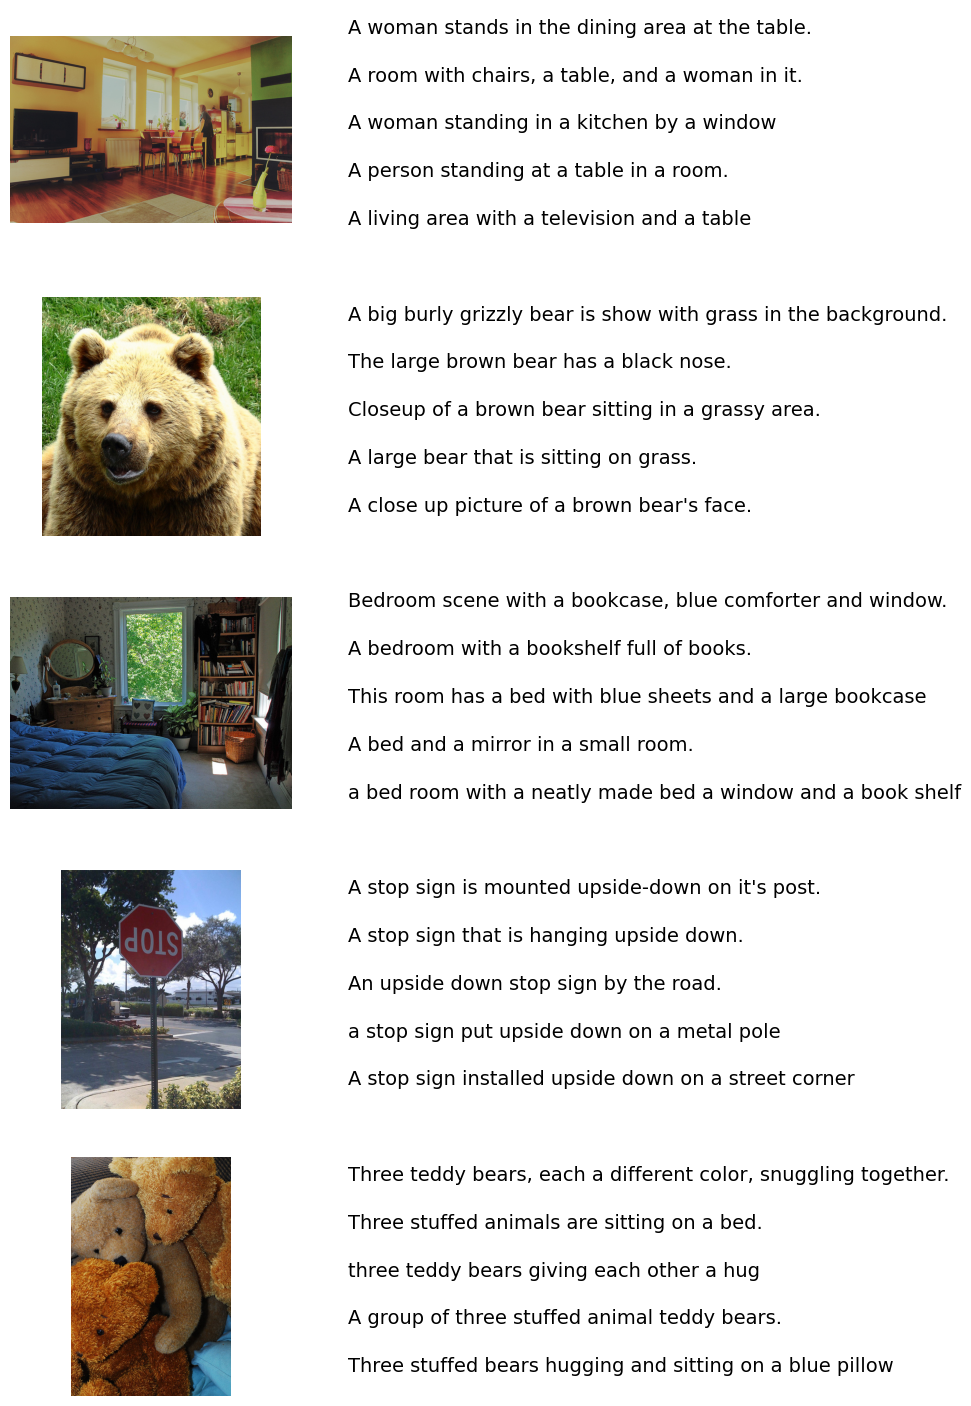

In [9]:
sample_data = test_captions_df.groupby("image_filepath")["caption"].agg(list).iloc[:5]

fig, axes = plt.subplots(5, 2, figsize=(8,18))

for ax_row, index, sample in zip(axes, sample_data.index, sample_data):
    
    ax_row[0].imshow(Image.open(index))
    ax_row[0].axis("off")
    text_y = 0.9
    for cap in sample:
        ax_row[1].text(0, text_y, cap, fontsize=14)
        text_y -= 0.2
    ax_row[1].axis("off")

In [10]:
n_samples = 1000

train_image_stats_df = train_captions_df.loc[:n_samples, "image_filepath"].apply(lambda x: Image.open(x).size)
train_image_stats_df = pd.DataFrame(train_image_stats_df.tolist(), index=train_image_stats_df.index)
train_image_stats_df.describe()

,0,1
count,788.000000,788.000000
mean,567.157360,498.809645
std,97.566102,99.834981
min,331.000000,182.000000
25%,480.000000,427.000000
50%,640.000000,480.000000
75%,640.000000,640.000000
max,640.000000,640.000000


In [11]:
train_vocabulary = train_captions_df["preprocessed_caption"].str.split(" ").explode().value_counts()
print(len(train_vocabulary[train_vocabulary>=25]))

3638


# Understanding the Bert Tokenizer

In [12]:
from tokenizers import BertWordPieceTokenizer

# Initialize an empty BERT tokenizer
tokenizer = BertWordPieceTokenizer(
    #reserved_tokens=["[UNK]", "[START]", "[END]", "[PAD]"],
    unk_token="[UNK]",
    #trainer_params=None,
    #vocab_size=8000,
    clean_text=False,
    lowercase=False,
)

tokenizer.train_from_iterator(
    train_captions_df["preprocessed_caption"].tolist(),
    vocab_size=4000,
    special_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]
)

In [13]:
# Encoding a sentence
example_captions = valid_captions_df["preprocessed_caption"].iloc[:10].tolist()
example_tokenized_captions = tokenizer.encode_batch(example_captions)

for caption, tokenized_cap in zip(example_captions, example_tokenized_captions):
    print(f"{caption} -> {tokenized_cap.tokens}")

[START] a very clean and well decorated empty bathroom [END] -> ['[START]', 'a', 'very', 'clean', 'and', 'well', 'decorated', 'empty', 'bathroom', '[END]']
[START] a blue and white bathroom with butterfly themed wall tiles [END] -> ['[START]', 'a', 'blue', 'and', 'white', 'bathroom', 'with', 'butter', '##fl', '##y', 'them', '##ed', 'wall', 'tiles', '[END]']
[START] a bathroom with a border of butterflies and blue paint on the walls above it [END] -> ['[START]', 'a', 'bathroom', 'with', 'a', 'bor', '##der', 'of', 'butter', '##fl', '##ies', 'and', 'blue', 'paint', 'on', 'the', 'walls', 'above', 'it', '[END]']
[START] an angled view of a beautifully decorated bathroom [END] -> ['[START]', 'an', 'ang', '##led', 'view', 'of', 'a', 'beautiful', '##ly', 'decorated', 'bathroom', '[END]']
[START] the vanity contains two sinks with a towel for each [END] -> ['[START]', 'the', 'vanity', 'contains', 'two', 'sinks', 'with', 'a', 'towel', 'for', 'each', '[END]']
[START] green tiled backsplash highli

In [14]:
vocab = tokenizer.get_vocab()

for token in ["[UNK]", "[PAD]", "[START]", "[END]"]:
    print(f"{token} -> {vocab[token]}")

[UNK] -> 1
[PAD] -> 0
[START] -> 2
[END] -> 3


# Defining the `tf.data.Dataset` for image captioning

In [15]:
def parse_image(filepath, resize_height, resize_width):
    image = tf.io.read_file(filepath)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [resize_height, resize_width])
    image = image*2.0 - 1.0
    return image

In [16]:
def generate_tokenizer(captions_df, n_vocab):
    """ Generate the tokenizer with given captions """
    
    # Define the tokenizer
    tokenizer = BertWordPieceTokenizer(
        unk_token="[UNK]",
        clean_text=False,
        lowercase=False,
    )
    
    # Train the tokenizer
    tokenizer.train_from_iterator(
        captions_df["preprocessed_caption"].tolist(),
        vocab_size=n_vocab,
        special_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]
    )
    
    return tokenizer

In [17]:
def generate_tf_dataset(image_captions_df, tokenizer=None, n_vocab=5000, pad_length=33, batch_size=32, training=False):
    """ Generate the tf.data.Dataset"""
    
    # If the tokenizer is not available, create one
    if not tokenizer:
        tokenizer = generate_tokenizer(image_captions_df, n_vocab)
        
    # Get the caption IDs using the tokenizer
    image_captions_df["caption_token_ids"] = [enc.ids for enc in tokenizer.encode_batch(image_captions_df["preprocessed_caption"])]
    
    vocab = tokenizer.get_vocab()
    
    # Add the padding to short sentences and truncate long ones
    image_captions_df["caption_token_ids"] = image_captions_df["caption_token_ids"].apply(
        lambda x: x+[vocab["[PAD]"]]*(pad_length - len(x) + 2) if pad_length + 2 >= len(x) else x[:pad_length + 1] + [x[-1]]
    ) 
    
    # Create a dataset with images and captions
    dataset = tf.data.Dataset.from_tensor_slices({
        "image_filepath": image_captions_df["image_filepath"],
        "caption_token_ids": np.array(image_captions_df["caption_token_ids"].tolist())
    })
    
    # Each sample in our dataset consists of
    # (image, caption token IDs, position IDs), (caption token IDs offset by 1)
    dataset = dataset.map(
        lambda x: (
            (parse_image(x["image_filepath"], 224, 224), x["caption_token_ids"][:-1], tf.range(pad_length+1, dtype='float32')), x["caption_token_ids"]
        )
    )
    
    # Shuffle and batch data in the training mode
    if training:
        dataset = dataset.shuffle(buffer_size=batch_size*10)
    
    dataset = dataset.batch(batch_size)
    
    return dataset, tokenizer

In [18]:
n_vocab=4000
batch_size=2
sample_dataset, sample_tokenizer = generate_tf_dataset(train_captions_df, n_vocab=n_vocab, pad_length=10, batch_size=batch_size, training=True)
for i in sample_dataset.take(1):
    print(i)




((<tf.Tensor: shape=(2, 224, 224, 3), dtype=float32, numpy=
array([[[[-0.34959733, -0.3629464 , -0.43932068],
         [-0.25675768, -0.26680666, -0.36203605],
         [-0.17223382, -0.18939072, -0.26907384],
         ...,
         [-0.96056587, -0.98127663, -1.        ],
         [-0.96172976, -0.98244053, -0.99662995],
         [-0.9795432 , -0.9838324 , -0.9957108 ]],

        [[-0.47532386, -0.47450978, -0.5141281 ],
         [-0.4415266 , -0.4537815 , -0.5031074 ],
         [-0.41738445, -0.4453256 , -0.47346812],
         ...,
         [-0.9663871 , -0.97423023, -1.        ],
         [-0.97191876, -0.97760844, -1.        ],
         [-0.9797976 , -0.9797976 , -0.99476564]],

        [[-0.454508  , -0.45916492, -0.5023546 ],
         [-0.43404233, -0.44775033, -0.48939073],
         [-0.4263655 , -0.44254202, -0.47463232],
         ...,
         [-0.94553614, -0.9732322 , -1.        ],
         [-0.9525386 , -0.98391116, -1.        ],
         [-0.96531916, -0.9789656 , -0.99

# Defining the model

Our model consists of,

* A Vision Transformer(ViT) - Takes in patches of images as inputs and produce a sequence of output representations for each patch
* A Text Decoder Transformer - Takes in the final representation of the vision Transformer, along with input caption IDs and predict the next token in the caption for each time step


In [19]:
import tensorflow_hub as hub
import tensorflow.keras.backend as K

K.clear_session()

image_input = tf.keras.layers.Input(shape=(224, 224, 3))
image_encoder = hub.KerasLayer("https://tfhub.dev/sayakpaul/vit_s16_fe/1", trainable=False)
image_features = image_encoder(image_input)
print(f"Final representation shape: {image_features.shape}")

Final representation shape: (None, 384)


## The Text Decoder Transformer

Here we define the text decoder. It takes the final image representation of ViT and concatenate that with caption IDs. Then we predict caption token ID from the next time step with the decoder.

In [20]:
class SelfAttentionLayer(tf.keras.layers.Layer):
    """ Defines the computations in the self attention layer """
    
    def __init__(self, d):        
        super(SelfAttentionLayer, self).__init__()
        # Feature dimensionality of the output
        self.d = d
    
    def build(self, input_shape):
        # Query weight matrix
        self.Wq = self.add_weight(
            shape=(input_shape[-1], self.d), initializer='glorot_uniform',
            trainable=True, dtype='float32'
        )        
        # Key weight matrix
        self.Wk = self.add_weight(
            shape=(input_shape[-1], self.d), initializer='glorot_uniform',
            trainable=True, dtype='float32'
        )
        # Value weight matrix
        self.Wv = self.add_weight(
            shape=(input_shape[-1], self.d), initializer='glorot_uniform',
            trainable=True, dtype='float32'
        )
    
    def call(self, q_x, k_x, v_x, mask=None):
        
        q = tf.matmul(q_x,self.Wq) #[None, t, d]
        k = tf.matmul(k_x,self.Wk) #[None, t, d]
        v = tf.matmul(v_x,self.Wv) #[None, t, d]
        
        # Computing the final output
        h = tf.keras.layers.Attention(causal=True)([
            q, #q
            v, #v
            k, #k
        ], mask=[None, mask]) # [None, t, t] . [None, t, d] => [None, t, d]
        
        return h
    
    
class TransformerDecoderLayer(tf.keras.layers.Layer):
    """ The Decoder layer """
    
    def __init__(self, d, n_heads):
        super(TransformerDecoderLayer, self).__init__()
        # Feature dimensionality
        self.d = d
        
        # Dimensionality of a head
        self.d_head = int(d/n_heads) 
        
        # Number of heads
        self.n_heads = n_heads
        
        # Actual attention heads
        self.attn_heads = [SelfAttentionLayer(self.d_head) for i in range(self.n_heads)]
        
        # Fully connected layers
        self.fc1_layer = tf.keras.layers.Dense(512, activation='relu')
        self.fc2_layer = tf.keras.layers.Dense(d)
        
        self.add_layer = tf.keras.layers.Add()
        self.norm1_layer = tf.keras.layers.LayerNormalization()
        self.norm2_layer = tf.keras.layers.LayerNormalization()
        
    
    def _compute_multihead_output(self, x):
        """ Computing the multi head attention output"""
        outputs = [head(x, x, x) for head in self.attn_heads]            
        outputs = tf.concat(outputs, axis=-1)
        return outputs
        
    def call(self, x):
        
        
        # Multi head attention layer output
        h1 = self._compute_multihead_output(x)
        
        h1_add = self.add_layer([x, h1])
        h1_norm = self.norm1_layer(h1_add)
        
        # Fully connected outputs
        h2_1 = self.fc1_layer(h1_norm)
        h2_2 = self.fc2_layer(h2_1)
        
        h2_add = self.add_layer([h1, h2_2])
        h2_norm = self.norm2_layer(h2_add)
        
        
        return h2_norm
    

# Input layer
caption_input = tf.keras.layers.Input(shape=(None,))
position_input = tf.keras.layers.Input(shape=(None,))
d_model = 384

# Token embeddings
input_embedding = tf.keras.layers.Embedding(len(tokenizer.get_vocab()), d_model, mask_zero=True)

# Position embeddings
position_embedding = tf.keras.layers.Lambda(
    lambda x: tf.where(
        tf.math.mod(tf.repeat(tf.expand_dims(x, axis=-1), d_model, axis=-1), 2)==0,
        tf.math.sin(
            #tf.repeat(tf.expand_dims(x, axis=-1), d_model, axis=-1) /
            tf.expand_dims(x, axis=-1) /
            10000**(2*tf.reshape(tf.range(d_model, dtype='float32'),[1,1, -1])/d_model)
        ),
        tf.math.cos(
            tf.expand_dims(x, axis=-1) /
            10000**(2*tf.reshape(tf.range(d_model, dtype='float32'),[1,1, -1])/d_model)
        )
    )
)

# Combined token position embeddings
embed_out = input_embedding(caption_input) + position_embedding(position_input)
# Concatenate image caption and token embeddings
image_caption_embed_out = tf.keras.layers.Concatenate(axis=1)([tf.expand_dims(image_features,axis=1), embed_out])

# Generate hidden representation with Transformer decoder layer
out = image_caption_embed_out
for l in range(4):
    out  = TransformerDecoderLayer(d_model, 64)(out)

# Final prediction layer
final_out = tf.keras.layers.Dense(n_vocab, activation='softmax')(out)

# Define the final model and compile
full_model = tf.keras.models.Model(inputs=[image_input, caption_input, position_input], outputs=final_out)
full_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')

full_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 keras_layer (KerasLayer)       (None, 384)          21665664    ['input_1[0][0]']            

## Defining the Blue Metric

In [21]:
import collections
import math


def _get_ngrams(segment, max_order):
    """Extracts all n-grams upto a given maximum order from an input segment.

      Args:
        segment: text segment from which n-grams will be extracted.
        max_order: maximum length in tokens of the n-grams returned by this
            methods.

      Returns:
        The Counter containing all n-grams upto max_order in segment
        with a count of how many times each n-gram occurred.
    """
    ngram_counts = collections.Counter()
    for order in range(1, max_order + 1):
        for i in range(0, len(segment) - order + 1):
            ngram = tuple(segment[i:i+order])
            ngram_counts[ngram] += 1
    return ngram_counts


def compute_bleu(reference_corpus, translation_corpus, max_order=4,
                 smooth=False):
    """Computes BLEU score of translated segments against one or more references.

      Args:
        reference_corpus: list of lists of references for each translation. Each
            reference should be tokenized into a list of tokens.
        translation_corpus: list of translations to score. Each translation
            should be tokenized into a list of tokens.
        max_order: Maximum n-gram order to use when computing BLEU score.
        smooth: Whether or not to apply Lin et al. 2004 smoothing.

      Returns:
        3-Tuple with the BLEU score, n-gram precisions, geometric mean of n-gram
        precisions and brevity penalty.
    """
    matches_by_order = [0] * max_order
    possible_matches_by_order = [0] * max_order
    reference_length = 0
    translation_length = 0
    for (references, translation) in zip(reference_corpus,
                                           translation_corpus):
        reference_length += min(len(r) for r in references)
        translation_length += len(translation)

        merged_ref_ngram_counts = collections.Counter()
        for reference in references:
            merged_ref_ngram_counts |= _get_ngrams(reference, max_order)
        translation_ngram_counts = _get_ngrams(translation, max_order)
        overlap = translation_ngram_counts & merged_ref_ngram_counts
        for ngram in overlap:
            matches_by_order[len(ngram)-1] += overlap[ngram]
        for order in range(1, max_order+1):
            possible_matches = len(translation) - order + 1
            if possible_matches > 0:
                possible_matches_by_order[order-1] += possible_matches

        precisions = [0] * max_order
        for i in range(0, max_order):
            if smooth:
                   precisions[i] = ((matches_by_order[i] + 1.) /
                           (possible_matches_by_order[i] + 1.))
            else:
                if possible_matches_by_order[i] > 0:
                    precisions[i] = (float(matches_by_order[i]) /
                             possible_matches_by_order[i])
                else:
                    precisions[i] = 0.0

        if min(precisions) > 0:
            p_log_sum = sum((1. / max_order) * math.log(p) for p in precisions)
            geo_mean = math.exp(p_log_sum)
        else:
            geo_mean = 0

        ratio = float(translation_length) / reference_length

        if ratio > 1.0:
            bp = 1.
        else:
            bp = math.exp(1 - 1. / ratio)

        bleu = geo_mean * bp

        return (bleu, precisions, bp, ratio, translation_length, reference_length)


In [22]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

class BLEUMetric(object):
    
    def __init__(self, tokenizer, name='bleu_metric', **kwargs):
        """ Computes the BLEU score (Metric for machine translation) """
        super().__init__()
        self.tokenizer = tokenizer
    
      #self.vocab = vocabulary
      #self.id_to_token_layer = StringLookup(vocabulary=self.vocab, num_oov_indices=0, oov_token='[UNKUNK]', invert=True)
    
    def calculate_bleu_from_predictions(self, real, pred):
        """ Calculate the BLEU score for targets and predictions """
        
        # Get the predicted token IDs
        pred_argmax = tf.argmax(pred, axis=-1)  
        
        # Convert token IDs to words using the vocabulary and the StringLookup
        pred_tokens = np.array([[self.tokenizer.id_to_token(pp) for pp in p] for p in pred_argmax])
        real_tokens = tf.constant([[self.tokenizer.id_to_token(rr) for rr in r] for r in real])
        
        def clean_text(tokens):
            
            """ Clean padding and other tokens to only keep meaningful words """
            
            # 3. Strip the string of any extra white spaces
            translations_in_bytes = tf.strings.strip(
                        # 2. Replace everything after the eos token with blank
                        tf.strings.regex_replace(
                            # 1. Join all the tokens to one string in each sequence
                            tf.strings.join(
                                tf.transpose(tokens), separator=' '
                            ),
                        "\[END\].*", ""),
                   )
            
            # Decode the byte stream to a string
            translations = np.char.decode( #
                translations_in_bytes.numpy().astype(np.bytes_), encoding='utf-8'
            )
            
            # If the string is empty, add a [UNK] token
            # Otherwise get a Division by zero error
            translations = [sent if len(sent)>0 else "[UNK]" for sent in translations ]
            
            # Split the sequences to individual tokens 
            translations = np.char.split(translations).tolist()
            
            return translations
        
        # Get the clean versions of the predictions and real seuqences
        pred_tokens = clean_text(pred_tokens)
        # We have to wrap each real sequence in a list to make use of a function to compute bleu
        real_tokens = [[token_seq] for token_seq in clean_text(real_tokens)]

        # The compute_bleu method accpets the translations and references in the following format
        # tranlation - list of list of tokens
        # references - list of list of list of tokens
        bleu, precisions, bp, ratio, translation_length, reference_length = compute_bleu(real_tokens, pred_tokens, smooth=False)

        return bleu

# Training the model

In [23]:
batch_size=96

train_fraction = 0.6
valid_fraction = 0.2

tokenizer = generate_tokenizer(
    train_captions_df, n_vocab=n_vocab
)

bleu_metric = BLEUMetric(tokenizer=tokenizer)

sampled_validation_captions_df = valid_captions_df.sample(frac=valid_fraction)

for e in range(5):
    print(f"Epoch: {e+1}")
    
    train_dataset, _ = generate_tf_dataset(
        train_captions_df.sample(frac=train_fraction), tokenizer=tokenizer, n_vocab=n_vocab, batch_size=batch_size, training=True
    )
    valid_dataset, _ = generate_tf_dataset(
        sampled_validation_captions_df, tokenizer=tokenizer, n_vocab=n_vocab, batch_size=batch_size, training=False
    )
    
    full_model.fit(
        train_dataset,
        epochs=1
    )
    
    valid_loss, valid_accuracy, valid_bleu = [], [], []
    for vi, v_batch in enumerate(valid_dataset):
        print(f"{vi+1} batches processed", end='\r')
        loss, accuracy = full_model.test_on_batch(v_batch[0], v_batch[1])
        batch_predicted = full_model(v_batch[0])
        bleu_score = bleu_metric.calculate_bleu_from_predictions(v_batch[1], batch_predicted)
        valid_loss.append(loss)
        valid_accuracy.append(accuracy)
        valid_bleu.append(bleu_score)
        
    print(
        f"\nvalid_loss: {np.mean(valid_loss)} - valid_accuracy: {np.mean(valid_accuracy)} - valid_bleu: {np.mean(valid_bleu)}"
    )




Epoch: 1
2071/2071 [==============================] - 1692s 721ms/step - loss: 1.3517 - accuracy: 0.7608
173 batches processed
valid_loss: 1.134343938675919 - valid_accuracy: 0.7831203045183524 - valid_bleu: 0.022141311889752237
Epoch: 2
2071/2071 [==============================] - 1476s 711ms/step - loss: 1.0708 - accuracy: 0.7899
173 batches processed
valid_loss: 1.0973282559758666 - valid_accuracy: 0.7856990946510624 - valid_bleu: 0.050972181452681106
Epoch: 3
2071/2071 [==============================] - 1472s 710ms/step - loss: 1.0348 - accuracy: 0.7936
173 batches processed
valid_loss: 1.0550943178937615 - valid_accuracy: 0.7914763926770646 - valid_bleu: 0.05261509712741182
Epoch: 4
2071/2071 [==============================] - 1471s 709ms/step - loss: 1.0270 - accuracy: 0.7938
173 batches processed
valid_loss: 1.0582506563622138 - valid_accuracy: 0.791956593535539 - valid_bleu: 0.05112908867896077
Epoch: 5
2071/2071 [==============================] - 1470s 709ms/step - loss: 1.